In [1]:
from salishsea_tools import viz_tools
from salishsea_tools.nowcast import research_VENUS, analyze
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
from dateutil import tz

import datetime

%matplotlib inline

In [2]:
sal_abs = 35.16504/35 

In [3]:
def calculate_density(t, s):
    """Caluclates the density given temperature in deg C (t)
    and salinity in psu (s).

    returns the density as an array (rho) kg/m^3
    """

    rho = (
        999.842594 + 6.793952e-2 * t
        - 9.095290e-3 * t*t + 1.001685e-4 * t*t*t
        - 1.120083e-6 * t*t*t*t + 6.536332e-9 * t*t*t*t*t
        + 8.24493e-1 * s - 4.0899e-3 * t*s
        + 7.6438e-5 * t*t*s - 8.2467e-7 * t*t*t*s
        + 5.3875e-9 * t*t*t*t*s - 5.72466e-3 * s**1.5
        + 1.0227e-4 * t*s**1.5 - 1.6546e-6 * t*t*s**1.5
        + 4.8314e-4 * s*s
        )

    return rho

In [4]:
start = datetime.datetime(2015,1,1)
end = datetime.datetime(2015, 11, 30)

files = analyze.get_filenames(start, end, '1d', 'grid_T', '/results/SalishSea/nowcast/')

In [5]:
SITES = research_VENUS.SITES['VENUS']
j = SITES['Central']['j']
i = SITES['Central']['i']
iee = SITES['East']['i']

iss = np.arange(i,iee) 
ks = np.arange(0,40)

In [6]:
sal, time = analyze.combine_files(files, 'vosaline', ks, j ,iss)
temp, time = analyze.combine_files(files, 'votemper', ks, j, iss)

In [7]:
sal=np.ma.masked_values(sal,0)
temp=np.ma.masked_values(temp,0)
rho = calculate_density(temp, sal)

In [8]:
mesh = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/mesh_mask_SalishSea2.nc')
tmask = mesh.variables['tmask'][0,:,j,iss]
gdept = mesh.variables['gdept'][0,:,j,iss]

klevels = np.argmax(tmask*gdept, axis=0)

Central density and salinity for 2015

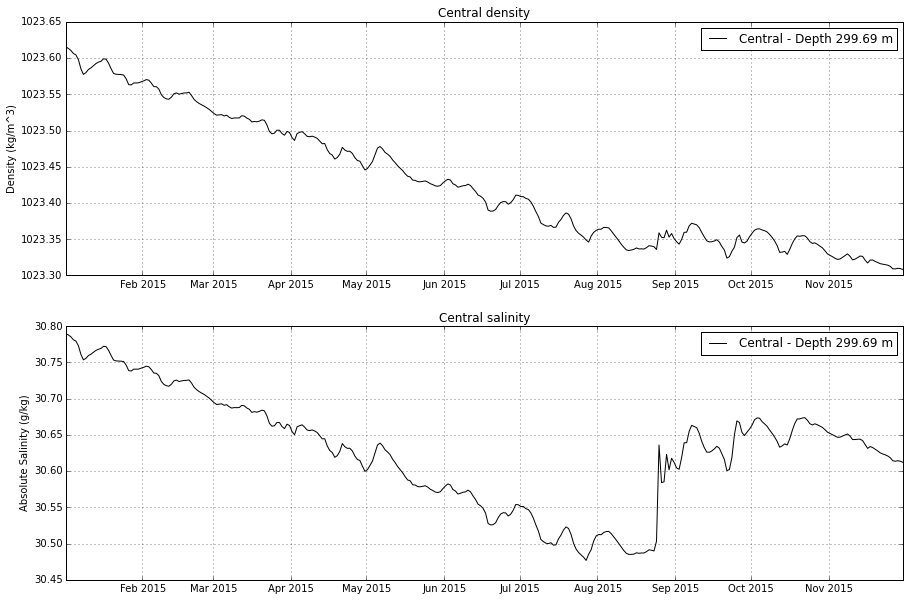

In [9]:
fig,axs = plt.subplots(2,1,figsize=(15,10))
ax=axs[0]
ax.plot(time, rho[:,klevels[0],iss[0]-i], 'k',
        label ='Central - Depth {0:1g} m'.format(gdept[klevels[0],iss[0]-i]))
ax.legend(loc=0); ax.grid()
ax.set_title('Central density')
ax.get_yaxis().get_major_formatter().set_useOffset(False)
ax.set_ylabel('Density (kg/m^3)')
ax=axs[1]
ax.plot(time, sal[:,klevels[0],iss[0]-i]*sal_abs , 'k',
        label ='Central - Depth {0:1g} m'.format(gdept[klevels[0],iss[0]-i]))
ax.legend(loc=0); ax.grid()
ax.set_title('Central salinity')
ax.set_ylabel('Absolute Salinity (g/kg)')

Density and salinity at points east Central

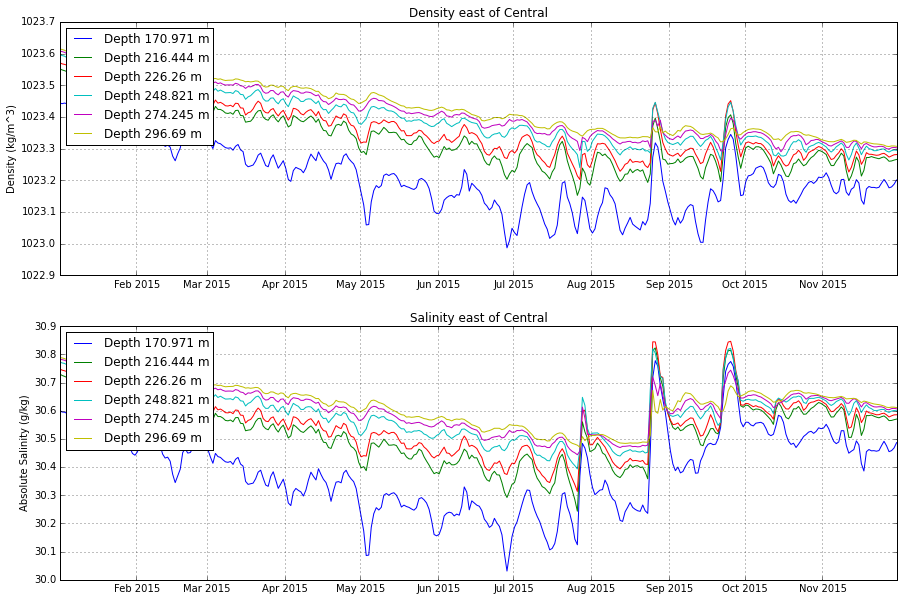

In [10]:
fig,axs = plt.subplots(2,1,figsize=(15,10))
ax=axs[0]
st=-3
for ind, k in zip(iss[-1:0:st]-i, klevels[-1:0:st]):
    ax.plot(time, rho[:,k,ind], label = 'Depth {0:1g} m'.format(gdept[k,ind]))
ax.get_yaxis().get_major_formatter().set_useOffset(False)
ax.set_ylabel('Density (kg/m^3)')
ax.set_title('Density east of Central')
ax.legend(loc=2); ax.grid()
ax=axs[1]
for ind, k in zip(iss[-1:0:st]-i, klevels[-1:0:st]):
    ax.plot(time, sal[:,k,ind]*sal_abs, label = 'Depth {0:1g} m'.format(gdept[k,ind]))
#ax.set_ylim([30,30.8])
ax.legend(loc=2); ax.grid()
ax.set_title('Salinity east of Central')
ax.set_ylabel('Absolute Salinity (g/kg)')

Plotting the positions of above lines relative to Central.

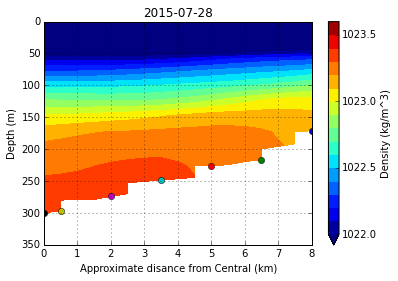

In [11]:
d = datetime.datetime(2015,7,28, 12, tzinfo=tz.tzutc())
t_ind = np.where(time==d)
xx,_ = np.meshgrid(np.arange(iss.shape[0]), gdept[:,0])
clevels = np.arange(1022,1023.6,.1)
m=plt.contourf(xx*.5, gdept, np.squeeze(rho[t_ind[0],:,:]) ,clevels, extend='min')
for ind, k in zip(iss[-1:0:st]-i, klevels[-1:0:st]):
    plt.plot(ind*.5,gdept[k,ind],'o')
plt.plot((iss[0]-i)*.5,gdept[klevels[0],iss[0]-i],'ok')
cbar=plt.colorbar(m, ticks=np.arange(1022,1024,.5))
cbar.set_ticklabels(np.arange(1022,1024,.5))
cbar.set_label('Density (kg/m^3)')
plt.axis([0,8,350,0])
plt.ylabel('Depth (m)')
plt.xlabel('Approximate disance from Central (km)')
plt.grid()
plt.title(d.strftime('%Y-%m-%d'))

Map

(48.5, 49.5)

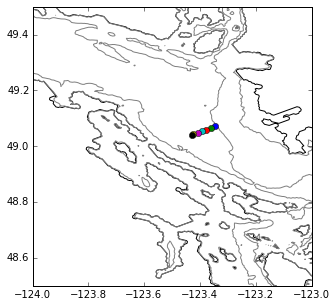

In [12]:
grid = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
lons = grid.variables['nav_lon']
lats = grid.variables['nav_lat']
fig,ax=plt.subplots(1,1,figsize=(5,5))
for ind in iss[-1:0:st]:
    plt.plot(lons[j,ind], lats[j,ind],'o')
plt.plot(lons[j,iss[0]],lats[j,iss[0]],'ok')
viz_tools.plot_coastline(ax,grid,coords='map')
viz_tools.plot_coastline(ax,grid,coords='map',isobath=5,color='gray')
viz_tools.plot_coastline(ax,grid,coords='map',isobath=170,color='gray')
ax.set_xlim([-124,-123])
ax.set_ylim([48.5,49.5])